## IL PROGETTO | BURSTECH INC.

- Il nostro progetto si focalizza sull'uso di un modello di Natural Language Processing (NLP) pre-trained per analizzare descrizioni delle classi di Dungeons and Dragons (D&D) presenti in file specifici. Implementiamo un sistema di Question and Answering (Q&A) che consente agli utenti di porre domande sulle informazioni delle classi e ricevere risposte accurate, introduciamo inolte anche la traduzione automatica dall'inglese all'italiano.Il processo coinvolge l'impiego di modelli di recupero e di lettura, insieme a tecniche di embedding per migliorare la comprensione del contesto e fornire risposte più precise.

# NLP (Natural Language Processing)

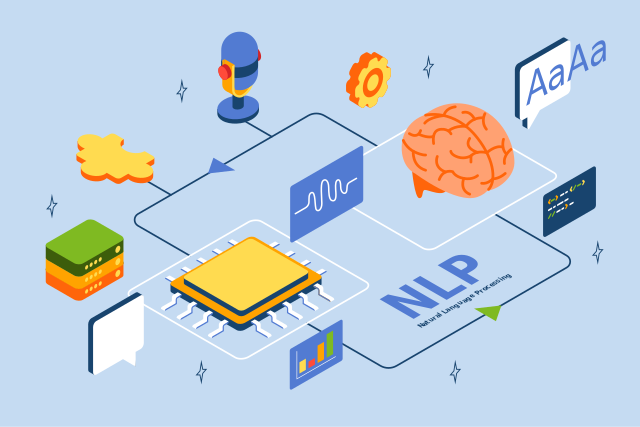

- Tokenizzazione: Il testo viene diviso in unità più piccole chiamate token, che possono essere parole o frasi.

- Analisi morfologica: Vengono analizzate le forme delle parole per comprendere la loro struttura e significato.

- Analisi sintattica: Si analizza la struttura grammaticale delle frasi per comprendere le relazioni tra le parole.

- Analisi semantica: Si cerca di comprendere il significato delle parole e delle frasi nel contesto.

- Disambiguazione semantica: Risolve ambiguità nel significato delle parole basandosi sul contesto.

- Rappresentazione del testo: Il testo viene convertito in una forma comprensibile per la macchina, spesso sotto forma di vettori numerici.

- Apprendimento automatico: I modelli NLP utilizzano algoritmi di apprendimento automatico per migliorare la comprensione del linguaggio e adattarsi a nuovi dati.

- Risposta e generazione di testo: La macchina è in grado di rispondere a domande, generare testo o compiere azioni basate sulla comprensione del linguaggio.

In [20]:
from haystack.document_stores import InMemoryDocumentStore
from haystack.pipelines import Pipeline, ExtractiveQAPipeline
from haystack.nodes import DensePassageRetriever, TextConverter, PreProcessor, FARMReader
from haystack.utils import print_answers
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
import os

Creazione del Document Store

In [2]:
doc_store = InMemoryDocumentStore()

Un retriever, nell'ambito del Natural Language Processing (NLP), è un componente di un sistema di Information Retrieval (IR) che si occupa di recuperare documenti rilevanti da una base di dati in risposta a una query posta dall'utente.

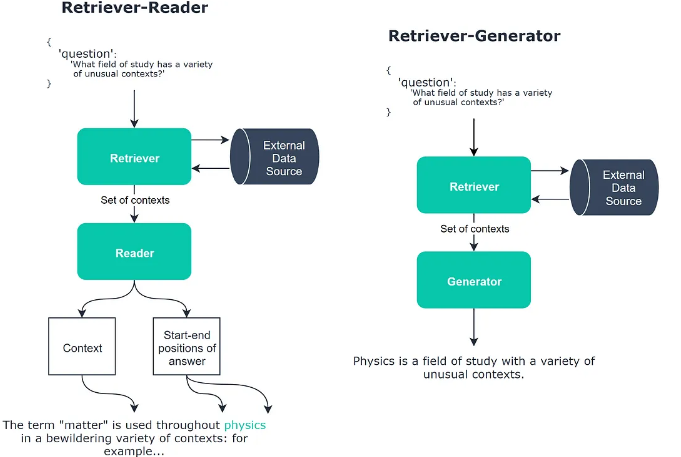

In [3]:
# Configurazione del Retriever:
retriever = DensePassageRetriever(document_store=doc_store)

c:\Users\MassimoCaso\anaconda3\envs\ML\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
text_converter = TextConverter()

In [5]:
preprocessor = PreProcessor(
    split_length=200,
    split_overlap=100
)

#### Creazione della pipe
- TextConverter
- PreProcessor
- DocumentStore

In [6]:
pipe = Pipeline()

In [7]:

pipe.add_node(component=text_converter, name="converter", inputs=["File"])
pipe.add_node(component=preprocessor, name="preprocessor", inputs=["converter"])
pipe.add_node(component=doc_store, name="store", inputs=["preprocessor"])

In [8]:

folder_name = "data\DnD Classes"
file_paths = [os.path.join(folder_name, filename) for filename in os.listdir(folder_name)]

pipe.run(file_paths=file_paths)

Converting files:   0%|          | 0/6 [00:00<?, ?it/s]

Preprocessing: 100%|██████████| 6/6 [00:00<00:00,  7.58docs/s]


{'documents': [<Document: {'content': "Class - Fighter\n\nLevel 1 - Fighting Style: You adopt a particular style of fighting as your specialty. Choose one of the following options: Archery, Defense, Dueling, Great Weapon Fighting, Protection, Two-Weapon Fighting. You can't take the same Fighting Style option more than once, even if you get to choose again.; Second Wind: You have a limited well of stamina that you can draw on to protect yourself from harm. On your turn, you can use a bonus action to regain hit points equal to 1d10 + your fighter level. Once you use this feature, you must finish a short or long rest before you can use it again.\n\nLevel 2 - Action Surge: Starting at 2nd level, you can push yourself beyond your normal limits for a moment. On your turn, you can take one additional action. Once you use this feature, you must finish a short or long rest before you can use it again. Starting at 17th level, you can use it twice before a rest, but only once on the same turn.\n\

In [9]:
for doc in doc_store.get_all_documents_generator():
    print(doc)
    break

<Document: id=1d1625192fe6e5e8d9886e9ea552f4ff, content='Class - Fighter

Level 1 - Fighting Style: You adopt a particular style of fighting as your specialt...'>


In [10]:
len(doc_store.get_all_documents())

673

# Embedding

![Embeddings models.PNG](<attachment:Embeddings models.PNG>)
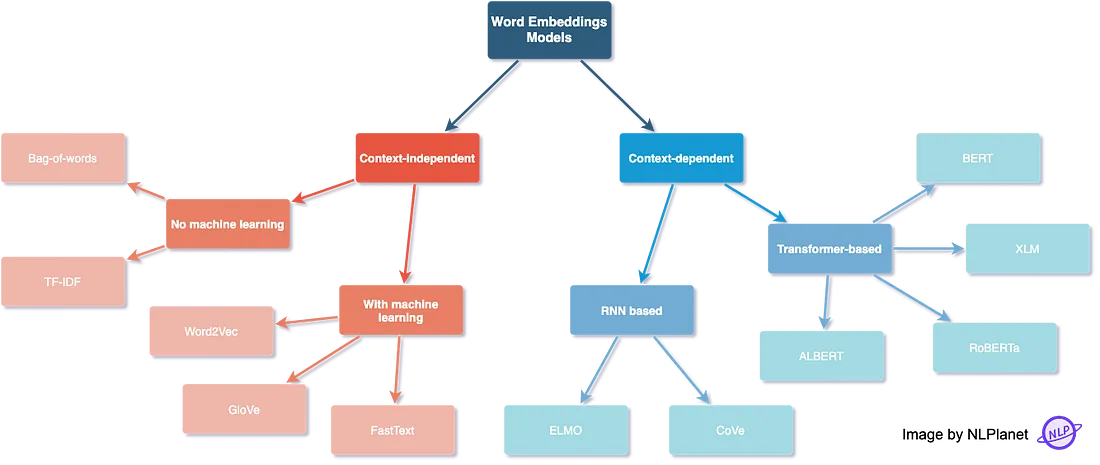

#### Cos'è l'Embedding?


L'embedding è una rappresentazione numerica di un'entità, come una parola o una frase, all'interno di uno spazio multidimensionale. In NLP, l'embedding viene spesso utilizzato per rappresentare parole o frasi in modo che la loro struttura e significato siano catturati in una forma numerica. Questa rappresentazione numerica è essenziale perché i modelli di machine learning operano su dati numerici e embedding, fornendo una trasformazione significativa del testo, consentono alle macchine di elaborare e comprendere il linguaggio.

Gli embedding vengono calcolati per i documenti utilizzando il retriever.

In [11]:
doc_store.update_embeddings(retriever=retriever)

Documents Processed: 10000 docs [09:27, 17.61 docs/s]          


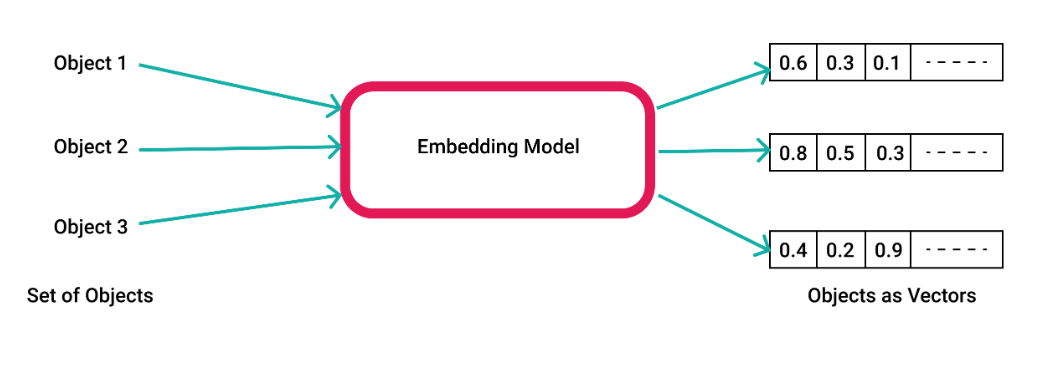

### ROBERTa
- RoBERTa utilizza un'operazione di mascheratura più aggressiva rispetto a BERT, mascherando più del 75% del testo in input. Ciò porta il modello a cercare relazioni più profonde tra le parole.
- RoBERTa è bidirezionale, ciò significa che può considerare contestualmente il contesto sia a sinistra che a destra di una parola nella sequenza rendendolo più potente per compiti di comprensione del linguaggio.
- Training di Fine Tuning

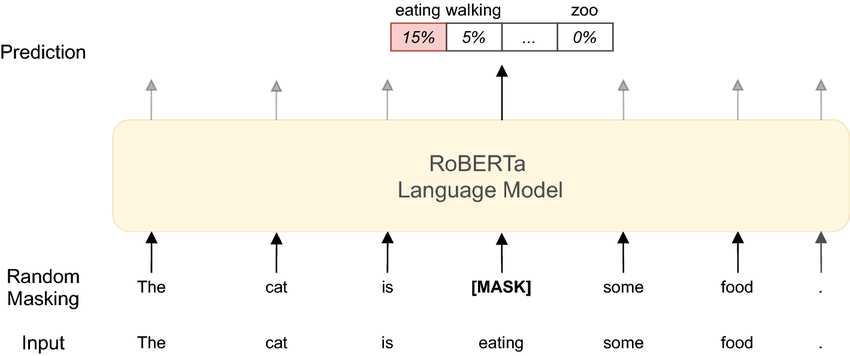

#### Multi-head self-attention e reti neurali feedforward
 - Ogni testa di attenzione calcola pesi di attenzione per ciascun token rispetto a tutti gli altri token nella sequenza. Questi pesi riflettono l'importanza relativa dei token nel contesto.
- L'output di ciascuna testa di attenzione è quindi combinato per produrre una rappresentazione ponderata di tutti i token. Questo consente al modello di catturare relazioni e dipendenze complesse tra le parole.

#### Reti neurali feedforward  (BERT Transformer)
Ciascun token passa attraverso una serie di trasformazioni lineari e funzioni di attivazione, che modificano il suo embedding originale. Questo consente al modello di catturare relazioni complesse e modellare il contesto.


In [12]:
reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2", return_no_answer=False, top_k=100)

In [13]:
pipe_qa = ExtractiveQAPipeline(reader=reader, retriever=retriever)

#### Inserimento della domanda

In [14]:
ans = pipe_qa.run(query="What does the fighter get at level 2?", params={"Retriever": {"top_k": 20}})

Inferencing Samples: 100%|██████████| 1/1 [00:23<00:00, 23.80s/ Batches]


In [15]:
answer = ans["answers"][0]
print(answer.answer)

Action Surge


In [16]:
context = ans["answers"][0]
print(context.context)

 finish a short or long rest before you can use it again.

Level 2 - Action Surge: Starting at 2nd level, you can push yourself beyond your normal lim


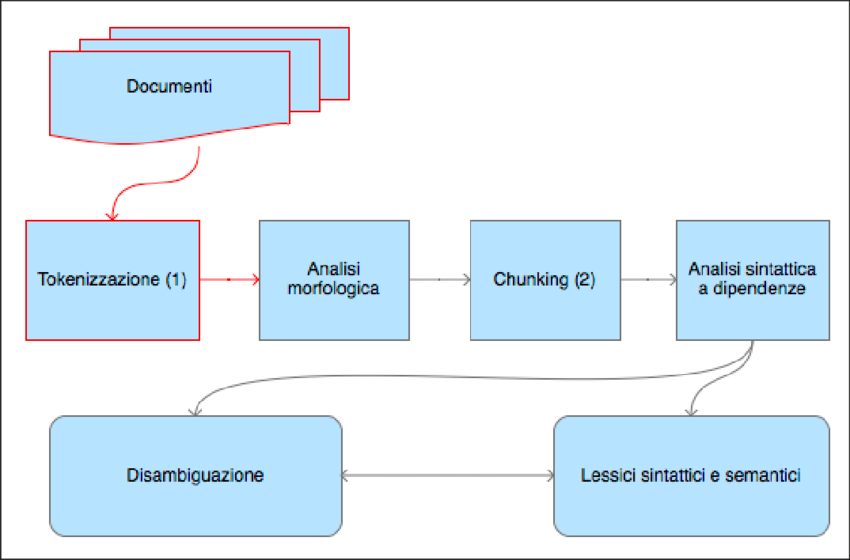

In [17]:
#Traduzione della risposta da inglese a italiano

answer_en = str(answer.answer).lower()

model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

# translate the text
tokenizer.src_lang = "en_XX"
encoded_en = tokenizer(answer_en, return_tensors="pt")
generated_tokens = model.generate(
    **encoded_en,
    forced_bos_token_id=tokenizer.lang_code_to_id["it_IT"]
)
answer_it = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)



c:\Users\MassimoCaso\anaconda3\envs\ML\Lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\MassimoCaso\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [18]:
print(f"Testo in inglese: {answer_en} | Testo tradotto in italiano: {answer_it[0]}")

Testo in inglese: action surge | Testo tradotto in italiano: L'influenza dell'azione


In [19]:
# Print delle altre possibili risposte con il relativo score
print_answers(ans, details="medium")

'Query: What does the fighter get at level 2?'
'Answers:'
[   {   'answer': 'Action Surge',
        'context': ' finish a short or long rest before you can use it again.\n'
                   '\n'
                   'Level 2 - Action Surge: Starting at 2nd level, you can '
                   'push yourself beyond your normal lim',
        'score': 0.847679853439331},
    {   'answer': 'bonus action',
        'context': 'vel, your quick thinking and agility grant you the ability '
                   'to take a bonus action during each of your turns in '
                   'combat. This bonus action can be employ',
        'score': 0.24924153089523315},
    {   'answer': '2d6',
        'context': 'her Levels. The spell’s damage increases by 1d6 when you '
                   'reach 5th level (2d6), 11th level (3d6), and 17th level '
                   '(4d6).\n'
                   '\n'
                   'Green-Flame Blade - Classes: ',
        'score': 0.06829077005386353},
    {   'answ